In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import h5py

In [199]:
from colossus.cosmology import cosmology
from colossus.lss.peaks import lagrangianR
cosmology.setCosmology('planck15')
cosmo = cosmology.getCurrent()
#R = lagrangianR(mass)
#sigma = cosmo.sigma(R, z)
k = 10**np.arange(-5,2,0.02)
power = cosmo.matterPowerSpectrum(k,z=0,model='eisenstein98')
#power05 = cosmo.matterPowerSpectrum(k,z=0.5,model='eisenstein98')
#power1 = cosmo.matterPowerSpectrum(k,z=1,model='eisenstein98')

In [200]:
cosmo.Om0

0.3089

In [201]:
from colossus.lss import bias
mass = np.logspace(9,15,20)
#M = np.logspace(9,15,20)
b0 = bias.haloBias(mass, model = 'cole89', z = 0)

b05 = bias.haloBias(mass, model = 'cole89', z = 0.5)

b1 = bias.haloBias(mass, model = 'cole89', z = 1)

#b2 = bias.haloBias(M, model = 'cole89', z = 3)

# $\sigma^2(M) = \frac{1}{2\pi^2}\int P(K)W^2(KR)k^2dk$

# $W(KR) = \frac{3(\sin(kR)-(kR)(\cos(kR))}{(kR)^3}$

In [202]:
def sigma(mass,redshift,kmin=-5,kmax=2):
    k_value = 10**np.arange(-5,2,0.02)
   # rho_m = 0.3089*8.5*1e-27
    R = lagrangianR(mass)
    #R = ((3*mass*2*1e30)/(4*np.pi*rho_m)**(1/3))*3.24078e-20
    #p = cosmo.matterPowerSpectrum(k_value,z=0, model='eisenstein98')
    #w = lambda k: (3/((k*R)**3))*(np.sin(k*R) - (k*R)*np.cos(k*R))
    
    integrated = lambda K: cosmo.matterPowerSpectrum(K,z=redshift, model='eisenstein98')*((3/((K*R)**3))*(np.sin(K*R) - (K*R)*np.cos(K*R)))**2*K**2
    #integrated = np.vectorize(integrated)
    
    sigma2 = scipy.integrate.quad(integrated,np.amin(k_value),np.amax(k_value))
    sigma2 = sigma2[0]/(2*(np.pi)**2)
    sigma = np.sqrt(sigma2)
    return (sigma)


In [203]:
sigma0 = []
sigma05 = []
sigma1 = []
sigma2=[]
sigma2_3=[]
sigma2_7=[]
sigma3=[]

for i in range(len(mass)):
    sigma0.append(sigma(mass[i],redshift = 0))
for i in range(len(mass)):
    sigma05.append(sigma(mass[i],redshift = 0.5))
for i in range(len(mass)):
    sigma1.append(sigma(mass[i],redshift = 1))
for i in range(len(mass)):
    sigma2.append(sigma(mass[i],redshift = 2))
for i in range(len(mass)):
    sigma2_3.append(sigma(mass[i],redshift = 2.3))
for i in range(len(mass)):
    sigma2_7.append(sigma(mass[i],redshift = 2.7))
for i in range(len(mass)):
    sigma3.append(sigma(mass[i],redshift = 3))

sigma0 = np.array(sigma0)
sigma05 = np.array(sigma05)
sigma1 = np.array(sigma1)
sigma2 = np.array(sigma2)
sigma2_3 = np.array(sigma2_3)
sigma2_7 = np.array(sigma2_7)
sigma3 = np.array(sigma3)


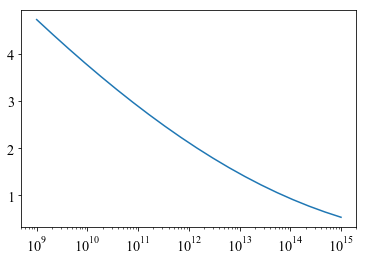

In [135]:
plt.plot(mass,sigma0)
plt.xscale('log')

# Press Schechter Bias

# $b(m,z) = 1 + \frac{1}{\delta_{cr}}[\delta_{cr}^2/\sigma^2(m,z)-1]$ 

# or

# $b(m,z) = 1 + \frac{[\delta_{cr}(z)^2/\sigma^2(m)-1]}{\frac{\delta_{cr}(z)}{\sigma(m)}\sigma(m,z)}$ 

# $\delta_{cr}(z) = \delta_{cr}(z=0)\frac{D(z=0)}{D(z)}$

# $D(z) = \frac{5}{2}\frac{\Omega_m(z)}{(1+z)}\frac{1}{\Omega_m(z)^{4/7}-\Omega_\Lambda(z) + [1+\Omega_m(z)/2][1+\Omega_\Lambda(z)/70] }$

# $\Omega_m(z) = \frac{\Omega_{m0}}{\Omega_{m0}+a^3\Omega_{\Lambda0}}$

# $\Omega_\Lambda(z) = \frac{\Omega_{0\Lambda}}{\Omega_{0\Lambda}+\Omega_{0m}/a^3}$

# $a = \frac{1}{1+z}$

In [204]:
omegam=0.3089
omegal=0.6910088292453472
def D(z):
    a = 1/(1+z)
    omega_m_z = omegam/(omegam+omegal*(a**3))
    omega_L_z = omegal/(omegam*(1/(a**3))+omegal)
    D = (5/2)*(omega_m_z/(1+z))*(1/((omega_m_z)**(4/7)-omega_L_z+((1+omega_m_z/2)*(1+omega_L_z/70))))
    return(D)                                                             

In [205]:
help

Type help() for interactive help, or help(object) for help about object.

In [206]:
def PS_bias1(m,sigma,sigma_z,redshift):
    dc_z = 1.686*D(z=0)/D(z=redshift)
    dc = 1.686
   # b = 1 + (1/dc)*((dc/sigma)**2 - 1)
    b = (dc_z**2/sigma**2 - 1)/(dc_z/sigma*sigma_z) + 1
    return(b)

In [139]:
def PS_bias2(m,sigma_z,redshift):
    #dc_z = 1.686*D(z=0)/D(z=redshift)
    dc = 1.686
   # b = 1 + (1/dc)*((dc/sigma)**2 - 1)
    b = (1/dc)*((dc/sigma_z)**2-1) + 1
    return(b)

In [207]:
bias0 = PS_bias1(mass,sigma0,sigma0,0)
bias05 = PS_bias1(mass,sigma0,sigma05,0.5)
bias1 = PS_bias1(mass,sigma0,sigma1,1)
#bias2 = PS_bias(mass,sigma0,2)


In [208]:
bias0_new = PS_bias2(mass,sigma0,0)
bias05_new = PS_bias2(mass,sigma05,0.5)
bias1_new = PS_bias2(mass,sigma1,1)

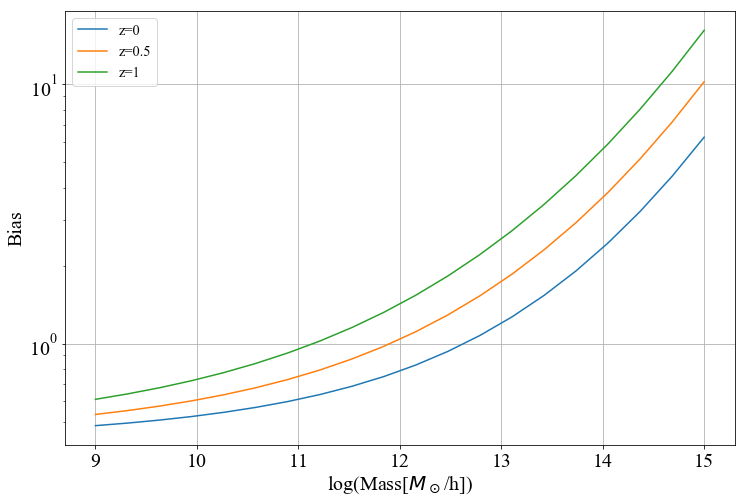

In [209]:
fig = plt.figure(figsize=(12,8))
csfont = {'fontname':'Times New Roman'}
params = {'legend.fontsize': 'x-large',
          'font.family':'Times New Roman',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)                

#ax.fill_between(bincenters,corr_rand_mean - corr_rand_std,corr_rand_mean + corr_rand_std,color = 'lightgreen')
#ax.grid('on'),xlabel='$log(M_* h/M_0)$',ylabel = '$log[n(>M)h^3/Mpc^3]$'
#ax.tick_params(direction='out', length=2, width=2, colors='black',
              # grid_color='r', grid_alpha=0.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$Mass[M_o]$',fontsize=20)
plt.ylabel('$\sigma(M)$',fontsize=20)
#plt.xscale('log')

plt.plot(np.log10(mass),bias0,label='z=0')
plt.plot(np.log10(mass),bias05,label='z=0.5')
plt.plot(np.log10(mass),bias1,label='z=1')

#plt.plot(np.log10(mass),bias0_new,label='$z=0$')
#plt.plot(np.log10(mass),bias05_new,label='$z=0.5$')
#plt.plot(np.log10(mass),bias1_new,label='$z=1$')


#plt.plot(np.log10(mass),b0,label='$z=0$')
#plt.plot(np.log10(mass),b05,label='$z=1$')
#plt.plot(np.log10(mass),b1,label='$z=2$')
#plt.xscale('log')
plt.xlabel('log(Mass[$M_\odot$/h])',fontsize=20)
plt.ylabel('Bias',fontsize=20)
plt.grid('on')
plt.yscale('log')
plt.legend(loc=0)
#plt.xscale('log')
#plt.yscale('log')
#plt.savefig('ps_bias_z.eps')

In [210]:
xi0_ps = (bias0)**2*(D(z=0)**2)
xi05_ps= (bias05)**2*(D(z=0.5)**2)
xi1_ps= (bias1)**2*(D(z=1)**2)

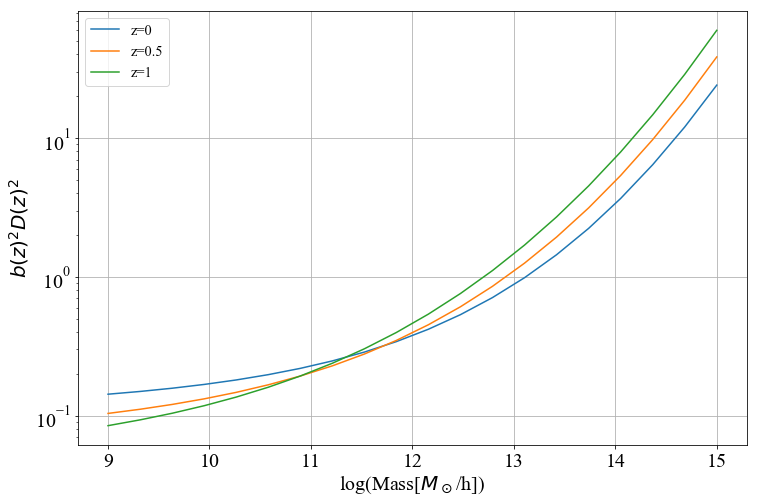

In [211]:
fig = plt.figure(figsize=(12,8))
csfont = {'fontname':'Times New Roman'}
params = {'legend.fontsize': 'x-large',
          'font.family':'Times New Roman',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)                

#ax.fill_between(bincenters,corr_rand_mean - corr_rand_std,corr_rand_mean + corr_rand_std,color = 'lightgreen')
#ax.grid('on'),xlabel='$log(M_* h/M_0)$',ylabel = '$log[n(>M)h^3/Mpc^3]$'
#ax.tick_params(direction='out', length=2, width=2, colors='black',
              # grid_color='r', grid_alpha=0.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$Mass[M_o]$',fontsize=20)
plt.ylabel('$\sigma(M)$',fontsize=20)
#plt.xscale('log')

plt.plot(np.log10(mass),xi0_ps,label='z=0')
plt.plot(np.log10(mass),xi05_ps,label='z=0.5')
plt.plot(np.log10(mass),xi1_ps,label='z=1')

#plt.plot(np.log10(mass),bias0_new,label='$z=0$')
#plt.plot(np.log10(mass),bias05_new,label='$z=0.5$')
#plt.plot(np.log10(mass),bias1_new,label='$z=1$')


#plt.plot(np.log10(mass),b0,label='$z=0$')
##plt.plot(np.log10(mass),b1,label='$z=1$')
#plt.plot(np.log10(mass),bias2,label='$z=2$')
#plt.xscale('log')
plt.xlabel('log(Mass[$M_\odot$/h])',fontsize=20)
plt.ylabel('$b(z)^2D(z)^2$',fontsize=20)
plt.grid('on')
plt.yscale('log')
plt.legend(loc=0)
#plt.xlim(10,12)
#plt.xscale('log')
#plt.yscale('log')
#plt.savefig('ps_bias_z.eps')

In [148]:
from colossus.lss import bias
mass = np.logspace(9,15,20)
#M = np.logspace(9,15,20)
b0 = bias.haloBias(mass, model = 'cole89', z = 0)
b025 = bias.haloBias(mass, model = 'cole89', z = 0.25)
b05 = bias.haloBias(mass, model = 'cole89', z = 0.5)
b075 = bias.haloBias(mass, model = 'cole89', z = 0.75)
b1 = bias.haloBias(mass, model = 'cole89', z = 1)

In [149]:
xi0 = (b0)**2*(cosmo.growthFactor(z=0)**2)
xi025 = (b025)**2*(cosmo.growthFactor(z=0.25)**2)
xi05= (b05)**2*(cosmo.growthFactor(z=0.5)**2)
xi075 = (b075)**2*(cosmo.growthFactor(z=0.75)**2)
xi1= (b1)**2*(cosmo.growthFactor(z=1)**2)

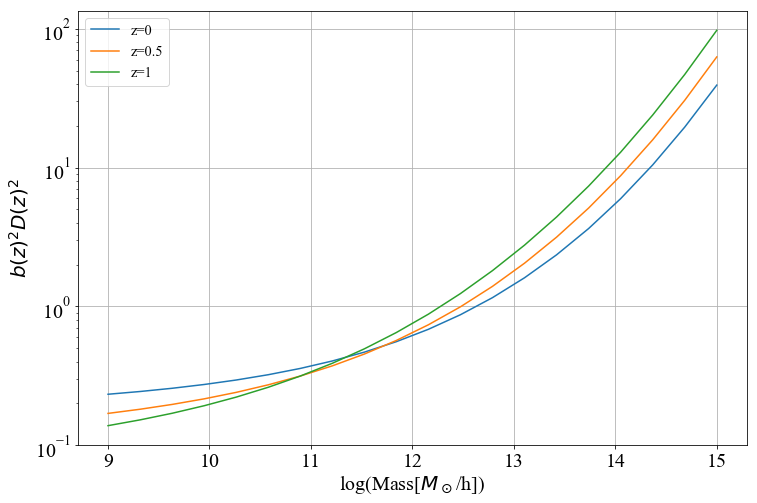

In [150]:
fig = plt.figure(figsize=(12,8))
csfont = {'fontname':'Times New Roman'}
params = {'legend.fontsize': 'x-large',
          'font.family':'Times New Roman',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)                

#ax.fill_between(bincenters,corr_rand_mean - corr_rand_std,corr_rand_mean + corr_rand_std,color = 'lightgreen')
#ax.grid('on'),xlabel='$log(M_* h/M_0)$',ylabel = '$log[n(>M)h^3/Mpc^3]$'
#ax.tick_params(direction='out', length=2, width=2, colors='black',
              # grid_color='r', grid_alpha=0.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$Mass[M_o]$',fontsize=20)
plt.ylabel('$\sigma(M)$',fontsize=20)
#plt.xscale('log')

plt.plot(np.log10(mass),xi0,label='z=0')
#plt.plot(np.log10(mass),xi025,label='z=0.25')
plt.plot(np.log10(mass),xi05,label='z=0.5')
#plt.plot(np.log10(mass),xi075,label='z=0.75')
plt.plot(np.log10(mass),xi1,label='z=1')

#plt.plot(np.log10(mass),bias0_new,label='$z=0$')
#plt.plot(np.log10(mass),bias05_new,label='$z=0.5$')
#plt.plot(np.log10(mass),bias1_new,label='$z=1$')


#plt.plot(np.log10(mass),b0,label='$z=0$')
##plt.plot(np.log10(mass),b1,label='$z=1$')
#plt.plot(np.log10(mass),bias2,label='$z=2$')
#plt.xscale('log')
plt.xlabel('log(Mass[$M_\odot$/h])',fontsize=20)
plt.ylabel('$b(z)^2D(z)^2$',fontsize=20)
plt.grid('on')
plt.yscale('log')
plt.legend(loc=0)
#plt.xlim(12.2,12.4)
#plt.xlim(11,12)
#plt.xscale('log')
#plt.yscale('log')
#plt.savefig('ps_bias_z.eps')

In [212]:
def sheth_thormen_bias(sigma_z):
    a = 0.707
    b = 0.5
    c = 0.6
    delta_c = 1.686
    nu = delta_c/sigma_z
    bias_st = 1 + 1/(np.sqrt(a)*delta_c)*(np.sqrt(a)*(a*nu**2)+np.sqrt(a)*b*(a*nu**2)**(1-c)-(a*nu**2)**c/(a*nu**2)**c+b*(1-c)*(1-c/2))
    return(bias_st)

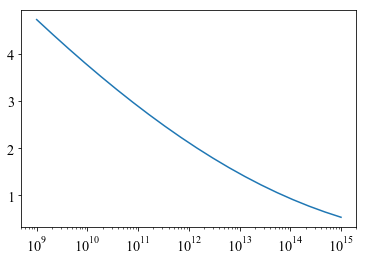

In [191]:
sigma2=[]
sigma2_3=[]
sigma2_7=[]
sigma3=[]
sigma0=[]
sigma05=[]
sigma1=[]
for i in range(len(mass)):
    sigma2.append(sigma(mass[i],redshift = 2))
for i in range(len(mass)):
    sigma2_3.append(sigma(mass[i],redshift = 2.3))
for i in range(len(mass)):
    sigma2_7.append(sigma(mass[i],redshift = 2.7))
for i in range(len(mass)):
    sigma3.append(sigma(mass[i],redshift = 3))
for i in range(len(mass)):
    sigma0.append(sigma(mass[i],redshift = 0))
for i in range(len(mass)):
    sigma05.append(sigma(mass[i],redshift = 0.5))
for i in range(len(mass)):
    sigma1.append(sigma(mass[i],redshift = 1))

sigma0 = np.array(sigma0)
sigma05 = np.array(sigma05)
sigma1 = np.array(sigma1)
sigma2 = np.array(sigma2)
sigma2_3 = np.array(sigma2_3)
sigma2_7 = np.array(sigma2_7)
sigma3 = np.array(sigma3)


plt.plot(mass,sigma0)
plt.xscale('log')

In [226]:
bias0 = sheth_thormen_bias(sigma0)
bias05 = sheth_thormen_bias(sigma05)
bias1 = sheth_thormen_bias(sigma1)
bias2 =sheth_thormen_bias(sigma2)
bias2_3 = sheth_thormen_bias(sigma2_3)
bias2_7 = sheth_thormen_bias(sigma2_7)
bias3 = sheth_thormen_bias(sigma3)

In [171]:
from colossus.lss import bias
mass = np.logspace(9,15,20)
#M = np.logspace(9,15,20)
b0 = bias.haloBias(mass, model = 'sheth01', z = 2)
b025 = bias.haloBias(mass, model = 'sheth01', z = 2.3)
b05 = bias.haloBias(mass, model = 'sheth01', z = 2.7)
b075 = bias.haloBias(mass, model = 'sheth01', z = 3)


In [184]:
bias3

array([ 1.2600778 ,  1.36361437,  1.48696778,  1.63513956,  1.81469646,
        2.03433826,  2.30572366,  2.6446642 ,  3.07288473,  3.62065456,
        4.33079101,  5.26486205,  6.5129826 ,  8.2096125 , 10.55955448,
       13.88162724, 18.68371355, 25.79475277, 36.60247665, 53.49280034])

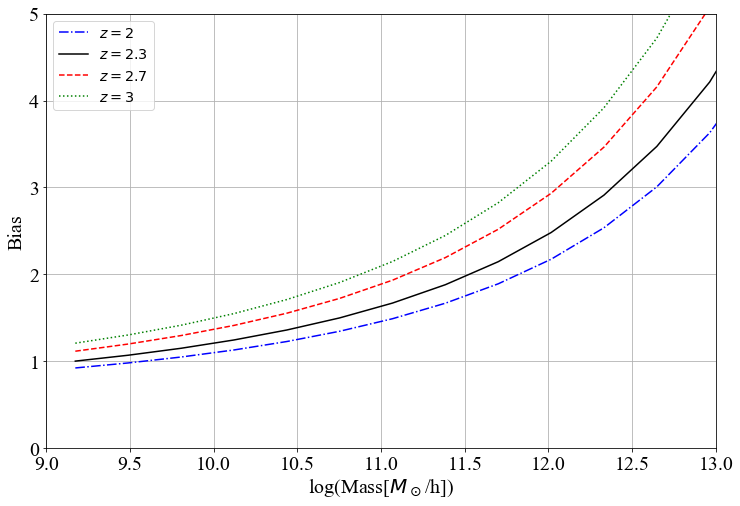

In [234]:
fig = plt.figure(figsize=(12,8))
csfont = {'fontname':'Times New Roman'}
params = {'legend.fontsize': 'x-large',
          'font.family':'Times New Roman',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)                

#ax.fill_between(bincenters,corr_rand_mean - corr_rand_std,corr_rand_mean + corr_rand_std,color = 'lightgreen')
#ax.grid('on'),xlabel='$log(M_* h/M_0)$',ylabel = '$log[n(>M)h^3/Mpc^3]$'
#ax.tick_params(direction='out', length=2, width=2, colors='black',
              # grid_color='r', grid_alpha=0.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$Mass[M_o]$',fontsize=20)
plt.ylabel('$\sigma(M)$',fontsize=20)
#plt.xscale('log')

#plt.plot(np.log10(mass),bias0,label='z=0')
#plt.plot(np.log10(mass),bias05,label='z=0.5')
#plt.plot(np.log10(mass),bias1,label='z=1')
plt.plot(np.log10(mass/0.67),bias2,'b-.',label='$z=2$')
plt.plot(np.log10(mass/0.67),bias2_3,'black',label='$z=2.3$')
plt.plot(np.log10(mass/0.67),bias2_7,'r--',label='$z=2.7$')
plt.plot(np.log10(mass/0.67),bias3,'g:',label='$z=3$')
#plt.plot(np.log10(mass),bias0_new,label='$z=0$')
#plt.plot(np.log10(mass),bias05_new,label='$z=0.5$')
#plt.plot(np.log10(mass),bias1_new,label='$z=1$')
plt.xlim(9,13)
plt.ylim(0,5)

#plt.plot(np.log10(mass),b0,label='$z=2$')
#plt.plot(np.log10(mass),b025,label='$z=2.3$')
#plt.plot(np.log10(mass),b05,label='$z=2.7$')
#plt.plot(np.log10(mass),b075,label='$z=3$')
#plt.xscale('log')
plt.xlabel('log(Mass[$M_\odot$/h])',fontsize=20)
plt.ylabel('Bias',fontsize=20)
plt.grid('on')
#plt.yscale('log')
plt.legend(loc=0)
#plt.xscale('log')
#plt.yscale('log')
#plt.savefig('ps_bias_z.eps')

In [227]:
xi0_st = (bias0)**2*(D(z=0))**2
#xi025 = (b025)**2*(cosmo.growthFactor(z=0.25)**2)
xi05_st= (bias05)**2*(D(z=0.5))**2
#xi075 = (b075)**2*(cosmo.growthFactor(z=0.75)**2)
xi1_st= (bias1)**2*(D(z=1))**2

In [189]:
xi0 = (b0)**2*(cosmo.growthFactor(z=0)**2)
xi025 = (b025)**2*(cosmo.growthFactor(z=0.25)**2)
xi05= (b05)**2*(cosmo.growthFactor(z=0.5)**2)
xi075 = (b075)**2*(cosmo.growthFactor(z=0.75)**2)
xi1= (b1)**2*(cosmo.growthFactor(z=1)**2)

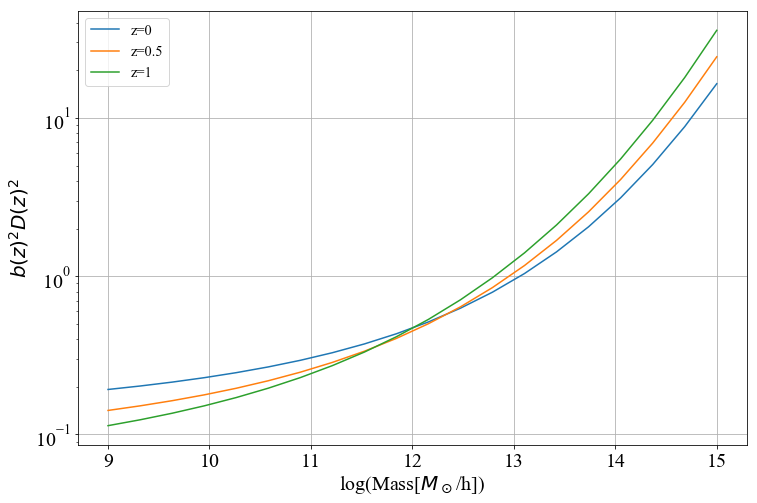

In [219]:
fig = plt.figure(figsize=(12,8))
csfont = {'fontname':'Times New Roman'}
params = {'legend.fontsize': 'x-large',
          'font.family':'Times New Roman',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)                

#ax.fill_between(bincenters,corr_rand_mean - corr_rand_std,corr_rand_mean + corr_rand_std,color = 'lightgreen')
#ax.grid('on'),xlabel='$log(M_* h/M_0)$',ylabel = '$log[n(>M)h^3/Mpc^3]$'
#ax.tick_params(direction='out', length=2, width=2, colors='black',
              # grid_color='r', grid_alpha=0.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$Mass[M_o]$',fontsize=20)
plt.ylabel('$\sigma(M)$',fontsize=20)
#plt.xscale('log')

plt.plot(np.log10(mass),xi0_st,label='z=0')
#plt.plot(np.log10(mass),xi025,label='z=0.25')
plt.plot(np.log10(mass),xi05_st,label='z=0.5')
#plt.plot(np.log10(mass),xi075,label='z=0.75')
plt.plot(np.log10(mass),xi1_st,label='z=1')

#plt.plot(np.log10(mass),bias0_new,label='$z=0$')
#plt.plot(np.log10(mass),bias05_new,label='$z=0.5$')
#plt.plot(np.log10(mass),bias1_new,label='$z=1$')


#plt.plot(np.log10(mass),b0,label='$z=0$')
##plt.plot(np.log10(mass),b1,label='$z=1$')
#plt.plot(np.log10(mass),bias2,label='$z=2$')
#plt.xscale('log')
plt.xlabel('log(Mass[$M_\odot$/h])',fontsize=20)
plt.ylabel('$b(z)^2D(z)^2$',fontsize=20)
plt.grid('on')
plt.yscale('log')
plt.legend(loc=0)
#plt.xlim(12.2,12.4)
#plt.xlim(12,12.5)
#plt.xlim(11,12)
#plt.xscale('log')
#plt.yscale('log')
#plt.savefig('ps_bias_z.eps')
#plt.xlim(12,12.5)

(10, 15)

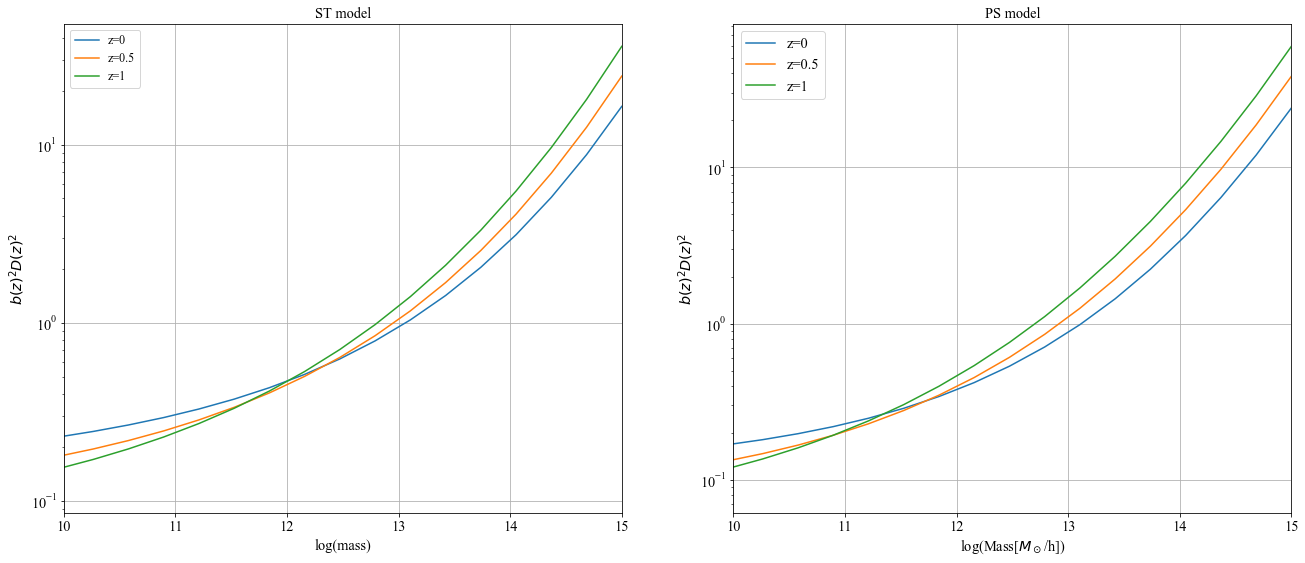

In [233]:
fig = plt.figure(figsize=(22,9))
csfont = {'fontname':'Times New Roman'}
params = {'legend.fontsize': 'x-large',
          'font.family':'Times New Roman',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)                

ax = fig.add_subplot(121,title = 'ST model',xlabel='log(mass)',ylabel = '$b(z)^2D(z)^2$')

ax.plot(np.log10(mass),xi0_st,label='z=0')
ax.plot(np.log10(mass),xi05_st,label='z=0.5')
ax.plot(np.log10(mass),xi1_st,label='z=1')
plt.legend(loc=0,fontsize=12)
plt.grid('on')
plt.yscale('log')
plt.xlim(10,15)
ax = fig.add_subplot(122,title = 'PS model',xlabel='log(mass)',ylabel = '$b(z)^2D(z)^2$')
#ax.plot(bincenters12,counts12,color = 'red')
ax.plot(np.log10(mass),xi0_ps,label='z=0')
ax.plot(np.log10(mass),xi05_ps,label='z=0.5')
ax.plot(np.log10(mass),xi1_ps,label='z=1')

#ax.errorbar(bins,g_1_mean12,yerr =g_1_std12 ,fmt ='o',color = 'green',label= '$z=1$')
#ax.plot(r,poisson_12,'^b',label='Poisson Distribution')
plt.grid('on')

#plt.plot(np.log10(mass),b0,label='$z=0$')
##plt.plot(np.log10(mass),b1,label='$z=1$')
#plt.plot(np.log10(mass),bias2,label='$z=2$')
#plt.xscale('log')
plt.xlabel('log(Mass[$M_\odot$/h])')
plt.ylabel('$b(z)^2D(z)^2$')
plt.grid('on')
plt.yscale('log')
plt.legend(loc=0)
#plt.xlim(12.2,12.4)
#plt.xlim(12,12.5)
#plt.xlim(11,12)
#plt.xscale('log')
#plt.yscale('log')
#plt.savefig('ps_bias_z.eps')
plt.xlim(10,15)